In [82]:
#Shruthi Sree Thirunavukkarasu 1001933428
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [83]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [84]:
%config InlineBackend.figure_format = 'retina'

In [85]:
RANDOM_SEED = 42
learn_rate = 0.001
n_epochs = 10
batchsize = 32
imgsize = 32
n_cls = 10

In [86]:
def train(train_load, model, crit, optimizer, device):
    model.train()
    run_loss = 0   
    for X, y_true in train_load:
        optimizer.zero_grad() 
        X = X.to(device)
        y_true = y_true.to(device)
        y_hat, _ = model(X) 
        loss = crit(y_hat, y_true) 
        run_loss += loss.item() * X.size(0)
        loss.backward()
        optimizer.step()
        
    epoch_loss = run_loss / len(train_load.dataset)
    return model, optimizer, epoch_loss

def training_loop(model, crit, optimizer, train_load, valid_loader, epochs, device, print_every=1):
    best_loss = 1e10
    train_loss = []
    valid_loss = []

    for epoch in range(0, epochs):
        model, optimizer, t_loss = train(train_load, model, crit, optimizer, device)
        train_loss.append(t_loss)
        with torch.no_grad():
            model, v_loss = validate(valid_loader, model, crit, device)
            valid_loss.append(v_loss)
        if epoch % print_every == (print_every - 1):   
            train_acc = get_acc(model, train_load, device=device)
            valid_acc = get_acc(model, valid_loader, device=device)     
            
            print(
                  f'Epoch: {epoch}\t'
                  f'Train loss: {t_loss:.4f}\t'
                  f'Valid loss: {v_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_loss, valid_loss)  
    return model, optimizer, (train_loss, valid_loss)

def get_acc(model, data_loader, device):   
    crct_pred = 0 
    a = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            _, y_prob = model(X)
            _, labels = torch.max(y_prob, 1)
            a += y_true.size(0)
            crct_pred += (labels == y_true).sum()
    return crct_pred.float() / a

def validate(valid_loader, model, crit, device):  
    model.eval()
    run_loss = 0   
    for X, y_true in valid_loader:    
        X = X.to(device)
        y_true = y_true.to(device)
        y_hat, _ = model(X) 
        loss = crit(y_hat, y_true) 
        run_loss += loss.item() * X.size(0)

    epoch_loss = run_loss / len(valid_loader.dataset)        
    return model, epoch_loss

def plot_losses(train_loss, valid_loss):
    plt.style.use('seaborn')
    train_loss = np.array(train_loss) 
    valid_loss = np.array(valid_loss)
    fig, axis = plt.subplots(figsize = (10, 5))
    axis.plot(train_loss, color='green', label='Training loss') 
    axis.plot(valid_loss, color='blue', label='Validation loss')
    axis.set(title="Epoch losses", 
            xlabel='Epoch',
            ylabel='Loss') 
    axis.legend()
    fig.show()

    

In [87]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

train_load = DataLoader(dataset=train_dataset, 
                          batch_size=batchsize, 
                          shuffle=True)

train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=batchsize, 
                          shuffle=False)

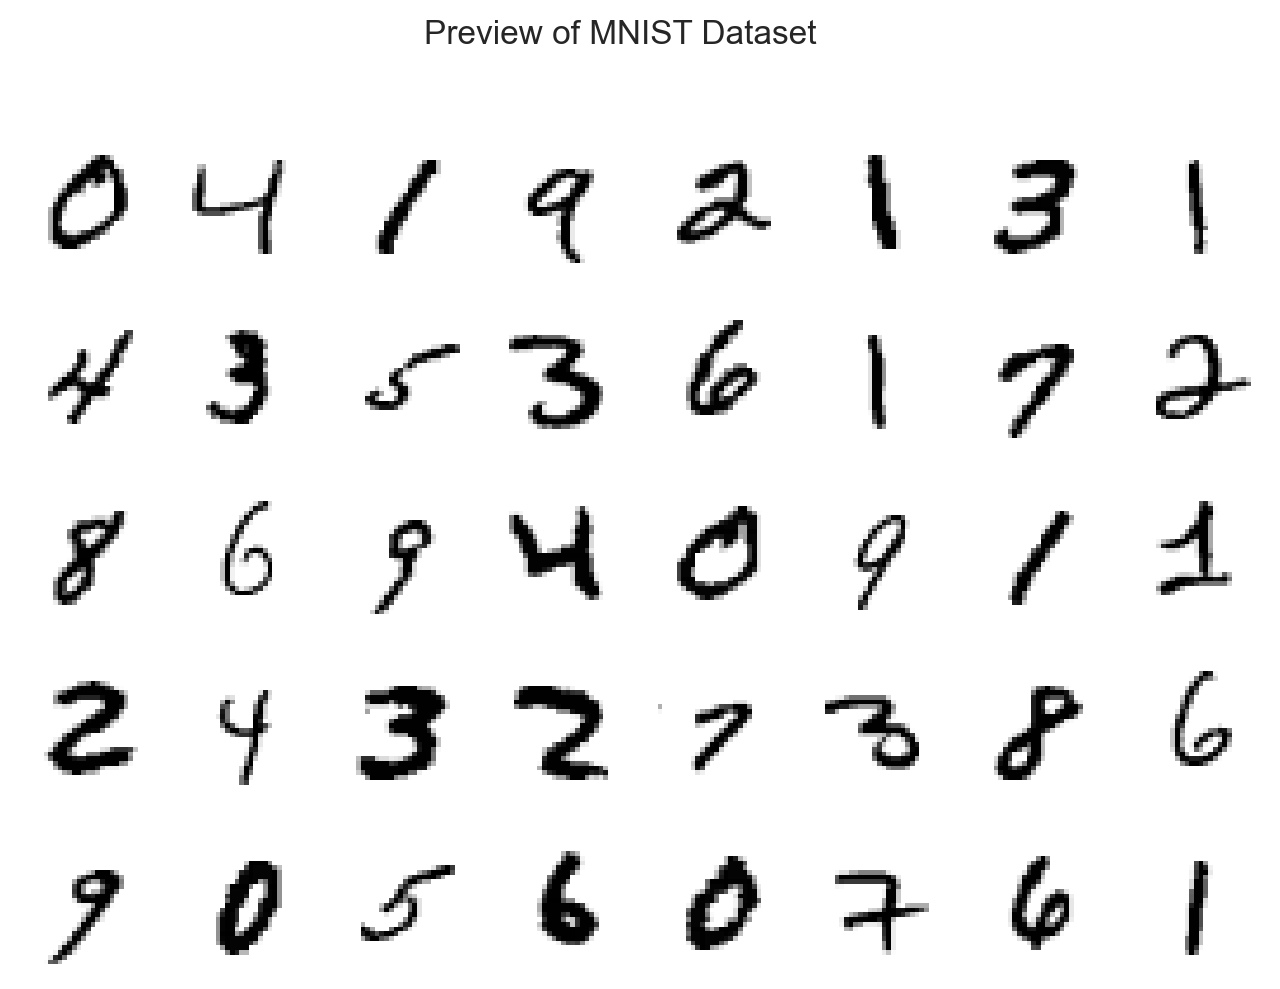

In [88]:
img_row = 8
rows = 5
fig = plt.figure()
for index in range(1, img_row * rows + 1):
    plt.subplot(rows, img_row, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index],cmap='gray_r')
fig.suptitle('Preview of MNIST Dataset');

In [89]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.24	Valid accuracy: 98.74
Epoch: 5	Train loss: 0.0297	Valid loss: 0.0439	Train accuracy: 99.36	Valid accuracy: 98.67
Epoch: 6	Train loss: 0.0246	Valid loss: 0.0418	Train accuracy: 99.53	Valid accuracy: 98.74
Epoch: 7	Train loss: 0.0218	Valid loss: 0.0482	Train accuracy: 99.41	Valid accuracy: 98.57
Epoch: 8	Train loss: 0.0200	Valid loss: 0.0436	Train accuracy: 99.60	Valid accuracy: 98.69
Epoch: 9	Train loss: 0.0168	Valid loss: 0.0515	Train accuracy: 99.48	Valid accuracy: 98.58


C:\Users\shruthi sree\AppData\Local\Temp\ipykernel_13980\3731004767.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


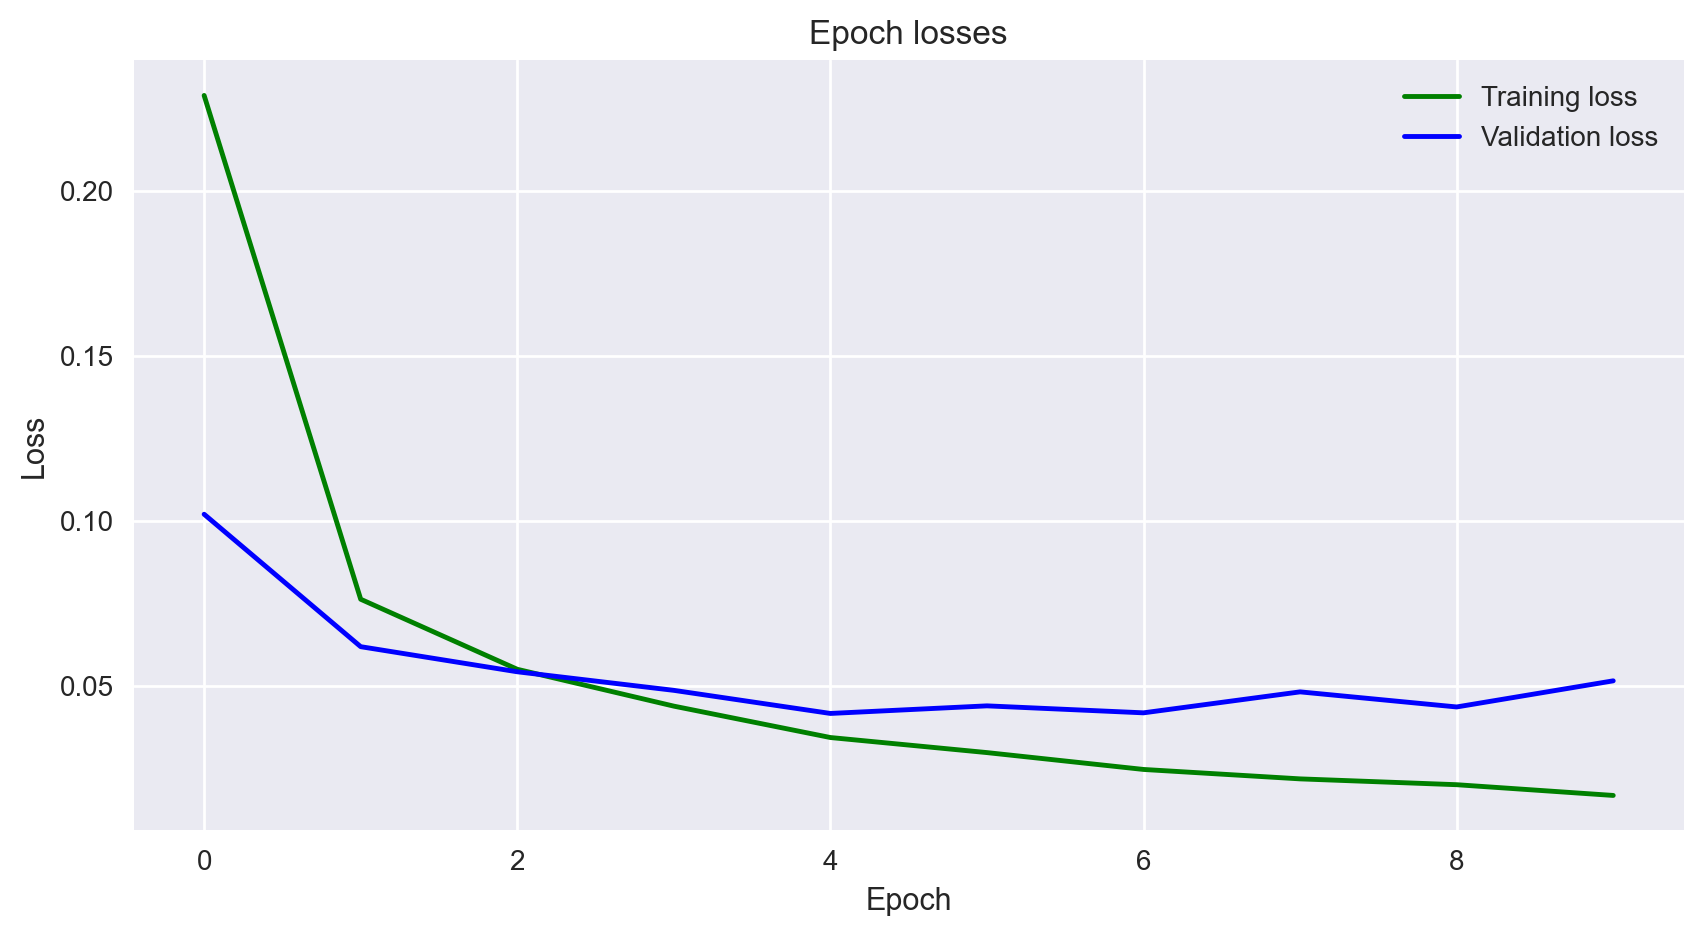

In [90]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(n_cls).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
crit = nn.CrossEntropyLoss()
model, optimizer, _ = training_loop(model, crit, optimizer, train_load, valid_loader, n_epochs, DEVICE)

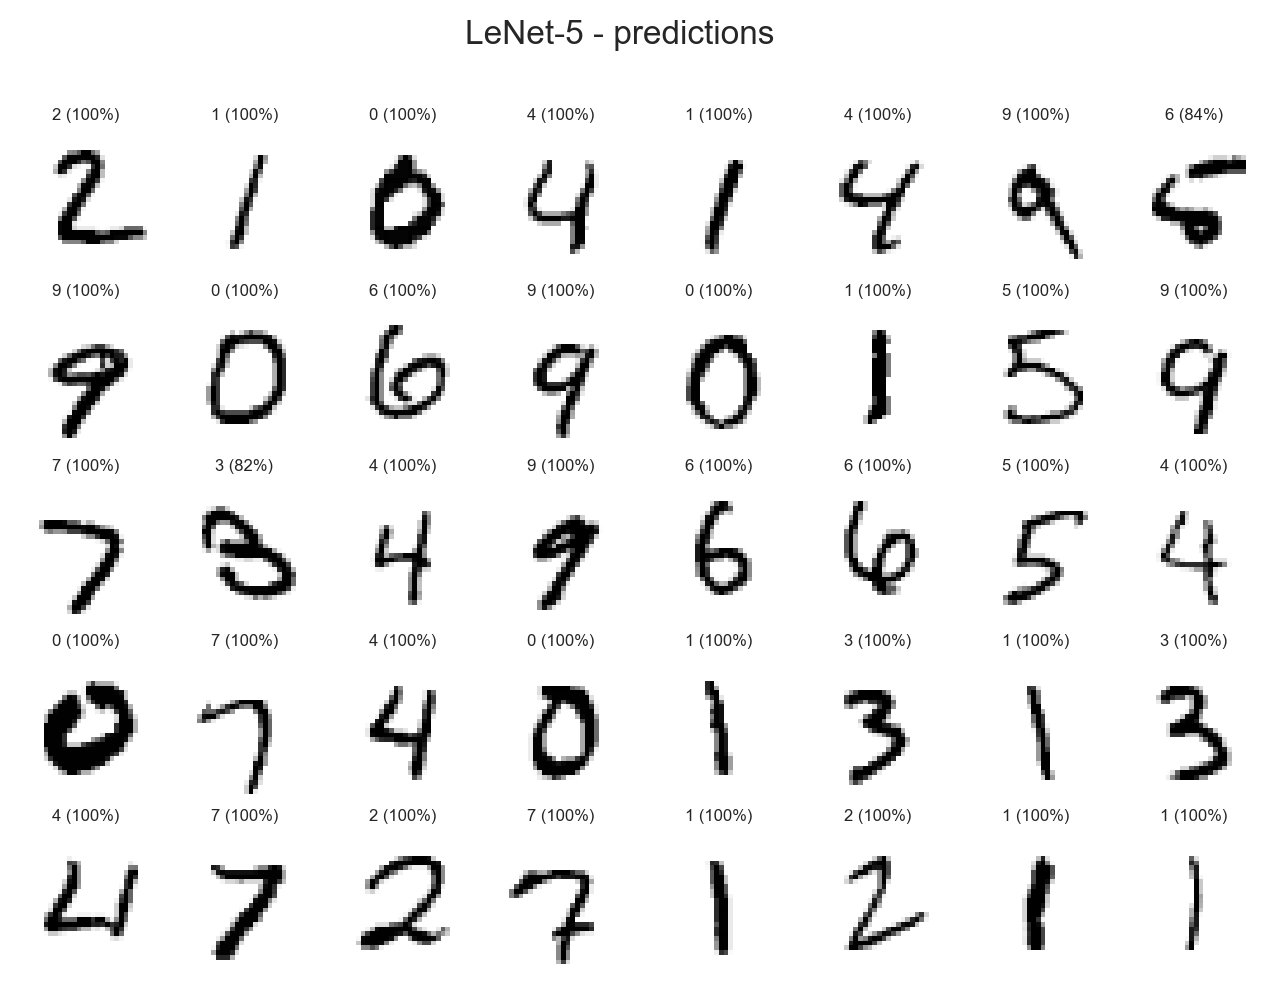

In [91]:
row_img = 10
rows = 5

fig = plt.figure()
for index in range(1, img_row * rows + 1):
    plt.subplot(rows, img_row, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=6)
fig.suptitle('LeNet-5 - predictions');